# imports

In [254]:
import datetime
import pandas as pd, numpy as np
import scipy
import matplotlib.pyplot as plt
from numpy_ext import rolling_apply as rolling_apply_ext
import talib
from talib import MA_Type

In [2]:
df = pd.read_csv('market_data_binance.by_minute_ALL_2022-09-19T04:00:00Z_2022-09-26T03:59:00Z.csv')
df['time'] = pd.to_datetime(df['timestamp'], unit='s')
df_close = df.pivot(index='time', columns='symbol', values='close')

In [3]:
def get_close_between_datetime(sample_period_minutes, symbols, start_datetime_str, end_datetime_str):   
    return df_close[(df_close.index >= start_datetime_str) & (df_close.index < end_datetime_str)][symbols].resample(f'{sample_period_minutes}min').last()

def get_close_between_date(sample_period_minutes, symbols, start_date_str, end_date_str):   
    return get_close_between_datetime(sample_period_minutes, symbols, start_date_str + " 00:00:000", end_date_str + " 00:00:000")

In [4]:
date_str_20220919 = "2022-09-19"
date_str_20220920 = "2022-09-20"
date_str_20220921 = "2022-09-21"
date_str_20220922 = "2022-09-22"
date_str_20220923 = "2022-09-23"
date_str_20220924 = "2022-09-24"
date_str_20220925 = "2022-09-25"
#symbols = ['YFIIUSDT', 'ETHUSDT', 'PAXGUSDT', 'BIFIUSDT', 'BNBUSDT']
symbols = ['YFIIUSDT', 'ETHUSDT', 'BIFIUSDT']

In [5]:
get_close_between_date(10, symbols, date_str_20220920, date_str_20220921)

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
time,,,
2022-09-20 00:00:00,893.5,1383.20,349.6
2022-09-20 00:10:00,886.7,1367.95,350.1
2022-09-20 00:20:00,886.3,1368.34,349.8
2022-09-20 00:30:00,884.1,1368.65,349.8
2022-09-20 00:40:00,880.3,1365.77,349.8
...,...,...,...
2022-09-20 23:10:00,863.7,1321.81,345.8
2022-09-20 23:20:00,866.6,1323.96,346.2
2022-09-20 23:30:00,863.3,1323.64,346.2


<Axes: xlabel='time'>

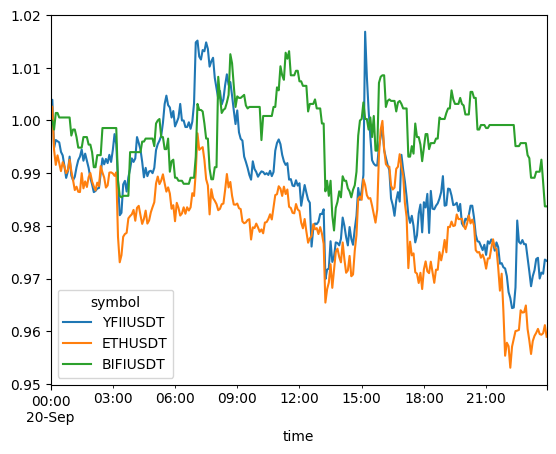

In [377]:
df = get_close_between_date(5, symbols, "2022-09-20", "2022-09-21")
(df / df.iloc[0]).plot()

# Sanity check: eigen values, vectors

In [6]:
mat = [[1, 2, 0], [2, 1, 0], [0, 0, 4]]
eiven_vals, eigen_vecs = np.linalg.eig(mat)

In [7]:
eiven_vals

array([ 3., -1.,  4.])

In [8]:
eigen_vecs

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].

In [9]:
eigen_vecs[:,0]

array([0.70710678, 0.70710678, 0.        ])

note that the matrix represenation is bit confusing. v[i,:] is *not* eigenvector, but v[:,i] is. So below is *not* an eigen vector.

In [10]:
eigen_vecs[0]

array([ 0.70710678, -0.70710678,  0.        ])

and accordingly the eigenvalues matix on the rhs is to be horizontally layed down.

In [11]:
eigen_vecs @ np.diag(eiven_vals) @ eigen_vecs.T

array([[1., 2., 0.],
       [2., 1., 0.],
       [0., 0., 4.]])

In [12]:
mat @ eigen_vecs[:,0]

array([2.12132034, 2.12132034, 0.        ])

# Solve the minimal predictability condition

<Axes: xlabel='time'>

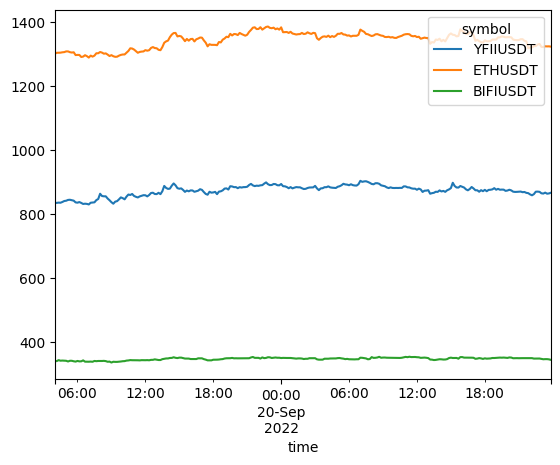

In [13]:
get_close_between_date(10, symbols, "2022-09-19", "2022-09-21").plot()

In [14]:
get_close_between_date(10, symbols, "2022-09-19", "2022-09-21").corr().style.background_gradient(cmap='coolwarm')

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
symbol,,,
YFIIUSDT,1.000000,0.930983,0.824657
ETHUSDT,0.930983,1.000000,0.867188
BIFIUSDT,0.824657,0.867188,1.000000


In [15]:
get_close_between_date(1, symbols, "2022-09-19", "2022-09-21").corr().style.background_gradient(cmap='coolwarm')

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
symbol,,,
YFIIUSDT,1.000000,0.925849,0.821544
ETHUSDT,0.925849,1.000000,0.865456
BIFIUSDT,0.821544,0.865456,1.000000


In [16]:
get_close_between_date(10, symbols, "2022-09-19", "2022-09-24").corr().style.background_gradient(cmap='coolwarm')

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
symbol,,,
YFIIUSDT,1.000000,0.064190,0.479641
ETHUSDT,0.064190,1.000000,0.745906
BIFIUSDT,0.479641,0.745906,1.000000


In [17]:
get_close_between_date(1, symbols, "2022-09-19", "2022-09-24").corr().style.background_gradient(cmap='coolwarm')

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
symbol,,,
YFIIUSDT,1.000000,0.068271,0.480184
ETHUSDT,0.068271,1.000000,0.745821
BIFIUSDT,0.480184,0.745821,1.000000


the eigen_vecs are for calculation only, the actual distribution over the asset is returned in `wgts`.

In [18]:
def calc_autocov_matrix(arr, lag):
    m = arr.shape[0]  # sample size.
    arr_lead = arr[lag:]
    arr_lag = arr[:m-lag]
    return 1.0 / (m - lag - 1) * (arr_lead - np.nanmean(arr_lead, axis=0)).T @ (arr_lag - np.nanmean(arr_lag, axis=0))

In [19]:
def get_var1_wgts_values_transpose(*df_values_T):
    cov = np.cov(df_values_T)
    cov_inv = np.linalg.inv(cov)
    cov_inv_sqrt = scipy.linalg.sqrtm(cov_inv)
    autocov = calc_autocov_matrix(np.transpose(df_values_T), 1)
    #var_predictability = cov_inv_sqrt @ autocov @ cov @ autocov.T @ cov_inv_sqrt.T
    var_predictability = cov_inv_sqrt @ autocov @ cov_inv @ autocov.T @ cov_inv_sqrt.T

    var_eigen_vals, var_eigen_vecs = np.linalg.eig(var_predictability)

    asc = np.argsort(var_eigen_vals)
    var_eigen_vals, var_eigen_vecs = var_eigen_vals[asc], var_eigen_vecs[:, asc]
    wgts = cov_inv_sqrt @ var_eigen_vecs
    if np.sign((np.transpose(df_values_T) @ wgts[:,0])[-1]) < 0:
        pass # var_eigen_vecs, wgts = var_eigen_vecs * -1, wgts * -1
    if np.sign(wgts[-1,0]) < 0:
        var_eigen_vecs, wgts = var_eigen_vecs * -1, wgts * -1
    return var_eigen_vals, var_eigen_vecs, wgts

In [20]:
def get_var1_wgts(df):
    return get_var1_wgts_values_transpose(*df.values.T)

The same function that takes df.values.T instead of df itself. This is used in the custom rolling function as the custom rolling function does not take the data frame but the arrays.

# Trading calculations

In [354]:
class TradingParam:
    def __init__(self, bb_windows, bb_stdev):
        self.bb_windows, self.bb_stdev = bb_windows, bb_stdev

def add_features(df_prices, wgt, trading_param):
    df_prices_weighted = df_prices * wgt
    df_prices_weighted['pos_mean_size'] = df_prices_weighted.where(df_prices_weighted > 0).mean(1)
    df_prices_weighted['neg_mean_size'] = df_prices_weighted.where(df_prices_weighted <= 0).mean(1)
    df_prices_weighted['mean_size'] = (df_prices_weighted['pos_mean_size'] - df_prices_weighted['neg_mean_size']) / 2.0
    values = df_prices_weighted.sum(axis=1).to_frame().rename(columns={0: 'value'})
    values['mean_size'] = df_prices_weighted['mean_size']

    upper, middle, lower = talib.BBANDS(values.value, trading_param.bb_windows, trading_param.bb_stdev, matype=MA_Type.T3)
    values['upper'] = upper
    values['lower'] = lower 
    upper, middle, lower, values = upper.dropna(), middle.dropna(), lower.dropna(), values.dropna()
    
    #values = values.copy()
    values['value_prev'] = values.value.shift()
    values['lower_crossed_upward'] = ((values.value_prev < lower) & (values.value >= lower)).astype(np.int32)
    values['lower_crossed_downward'] = ((values.value_prev > lower) & (values.value <= lower)).astype(np.int32)
    values['upper_crossed_upward'] = ((values.value_prev < upper) & (values.value >= upper)).astype(np.int32)
    values['upper_crossed_downward'] = ((values.value_prev > upper) & (values.value <= upper)).astype(np.int32)
    #values = values.dropna()

    in_positions = [0]
    for i in range(1, len(values.index)):
        in_position = in_positions[-1]
        # the position of current is one step delayed to make it more realistic.
        if values.lower_crossed_upward.values[i-1] > 0:
            in_position = 1
        elif values.upper_crossed_downward.values[i-1] > 0:
            in_position = 0
        in_positions.append(in_position)
    values['in_position'] = in_positions
    values['profit_raw'] = values.value.diff() * values.in_position
    values['profit'] = values.value.pct_change() * values.in_position
    values['position_changed'] = values.in_position.diff()

    position_sizes = [0]
    for i in range(1, len(values.index)):
        position_size = position_sizes[-1]
        # the position of current is one step delayed to make it more realistic.
        if values.position_changed.values[i] > 0:
            position_size = values.mean_size.values[i]
        if values.position_changed.values[i] < 0:
            position_size = 0
        position_sizes.append(position_size)
    values['position_size'] = position_sizes

    #values = values.dropna()

    if type(wgt) is np.ndarray:
        values['rebalanced'] = 0
    else:
        values['rebalanced'] = wgt.sum(axis=1).to_frame().diff().fillna(0)
    values = values.fillna(0)
    values['rebalanced'] = values[['rebalanced']].where(values.rebalanced == 0, 1)
    
    rebalance_ages = [1]
    for i in range(1, len(values.index)):
        rebalance_age = rebalance_ages[-1] + 1
        if values.rebalanced.values[i] > 0:
            rebalance_age = 1
        rebalance_ages.append(rebalance_age)
    values['rebalance_age'] = rebalance_ages

    return values

# Static Portfolio construction

In [22]:
var_eigen_vals, var_eigen_vecs, wgts = get_var1_wgts_values_transpose(*get_close_between_date(10, symbols, date_str_20220919, date_str_20220921).values.T)

In [23]:
var_eigen_vals

array([0.65533985, 0.69709114, 0.9545689 ])

In [24]:
print(var_eigen_vecs[:,0])
print(wgts[:,0])

[-0.06932741 -0.15607084  0.9853099 ]
[-0.01691221 -0.06233537  0.5031666 ]


In [25]:
print(var_eigen_vecs[:,-1])
print(wgts[:,-1])

[0.48917415 0.85547329 0.16992381]
[0.00727594 0.03155427 0.02976713]


In [26]:
get_close_between_date(10, symbols, date_str_20220919, date_str_20220921).head(3)

symbol,YFIIUSDT,ETHUSDT,BIFIUSDT
time,,,
2022-09-19 04:00:00,834.2,1300.92,340.1
2022-09-19 04:10:00,834.6,1303.61,340.1
2022-09-19 04:20:00,835.4,1303.85,343.0


## Graphs

<Axes: xlabel='time'>

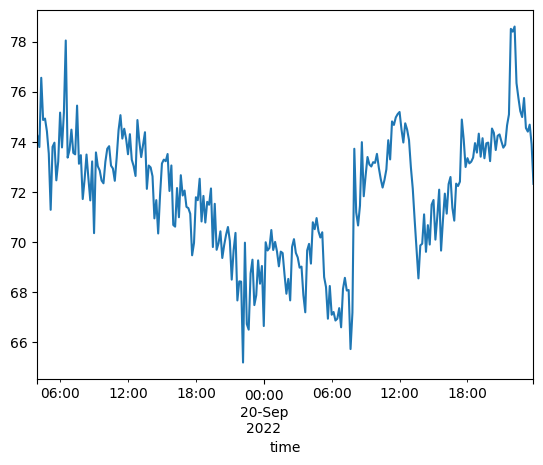

In [1019]:
(get_close_between_date(10, symbols, date_str_20220919, date_str_20220921) * var_eigen_vecs[:,0]).sum(axis=1).plot()

<Axes: xlabel='time'>

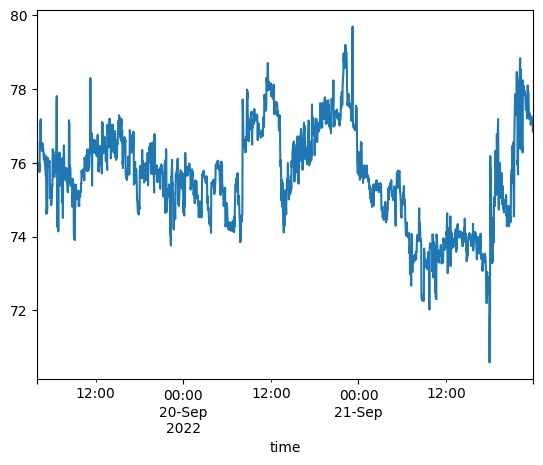

In [1020]:
(get_close_between_date(2, symbols, date_str_20220919, date_str_20220922) * wgts[:,0]).sum(axis=1).plot()

## Bollinger bands trading

In [368]:
trading_param = TradingParam(60, 2.5)
values = add_features(get_close_between_date(1, symbols, date_str_20220919, date_str_20220922), wgts[:,0], trading_param)

<Axes: xlabel='time'>

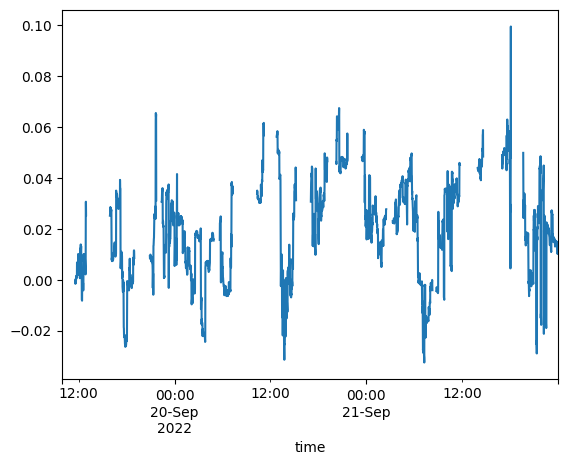

In [369]:
(values.profit_raw.cumsum() / values.position_size).plot()

<Axes: xlabel='time'>

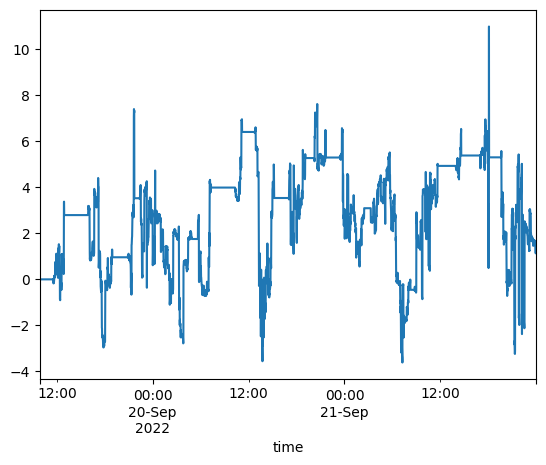

In [370]:
(values.profit_raw.cumsum()).plot()

<Axes: xlabel='time'>

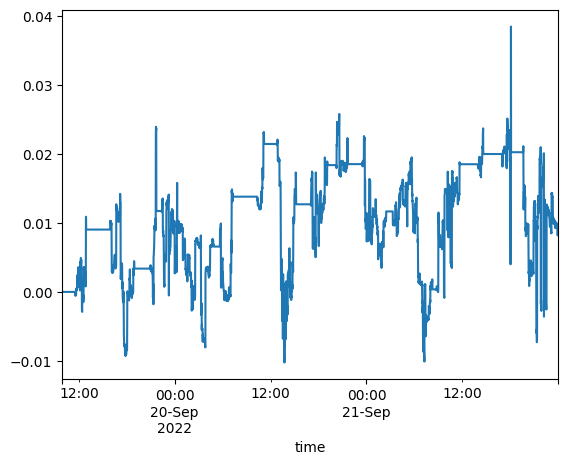

In [371]:
values.profit.cumsum().plot()

<Axes: xlabel='time'>

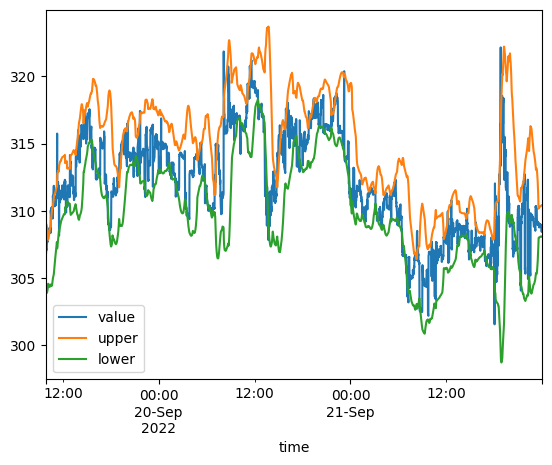

In [372]:
values[['value', 'upper', 'lower']].plot()

<Axes: xlabel='time'>

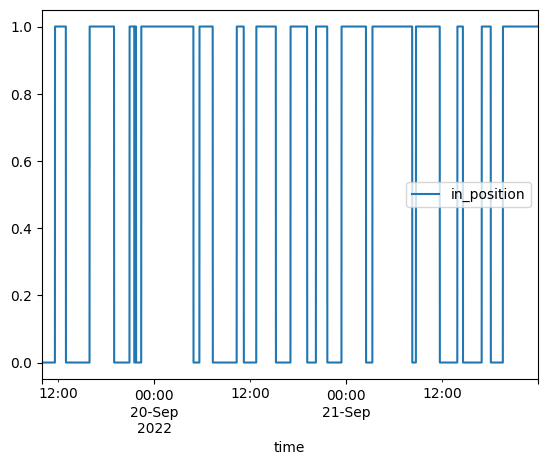

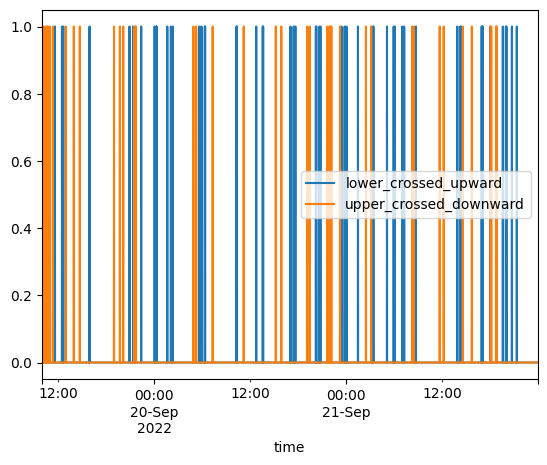

In [373]:
values[['in_position']].plot()
values[['lower_crossed_upward', 'upper_crossed_downward']].plot()

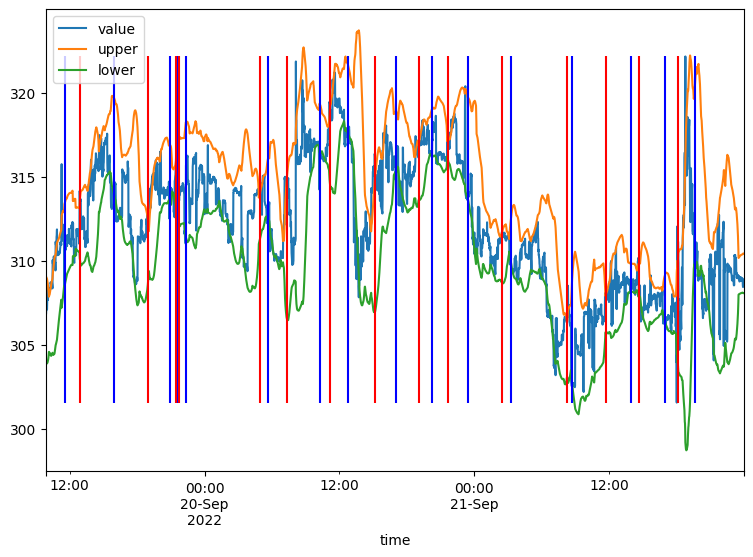

In [374]:
# plot dataframe; the index is a datetime index
ax = values[['value', 'upper', 'lower']].dropna().plot(figsize=(9, 6))
ymin, ymax = values.value.min(), values.value.max()

# add vertical lines
ax.vlines(x=list(values[values.position_changed == +1].index), ymin=ymin, ymax=ymax, color='b', label='test lines')
ax.vlines(x=list(values[values.position_changed == -1].index), ymin=ymin, ymax=ymax, color='r', label='test lines')

plt.show()

<Axes: xlabel='time'>

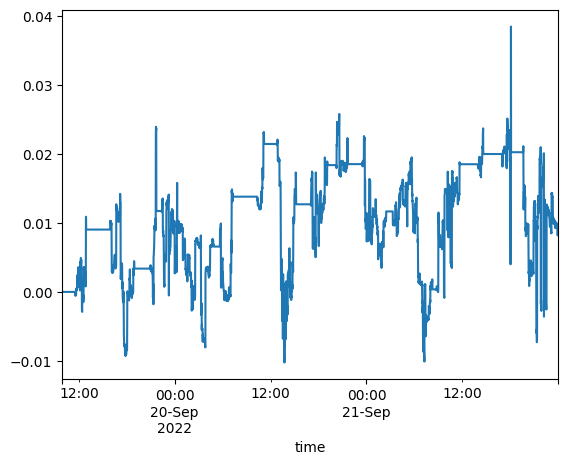

In [375]:
values.profit.cumsum().plot()

# Rolling-based Portfolio Construction

In [138]:
from numpy_ext import rolling_apply as rolling_apply_ext

In [233]:
def get_df_var1_eigenvecs_weights(df, window, step, sample_unit_minutes, order, if_evecs):
    '''
    order: 0 for the smallest eigen value, -1 for the largest.
    if_evecs: True for eigen vectors, False for weights (e-vecs / sqrt(cov))
    '''
    i = 1 if if_evecs else 2
    rolling_wgt = rolling_apply_ext(lambda *vsT: get_var1_wgts_values_transpose(*vsT)[i][:,order], window, *df.values.T)
    df_rolling_wgt = pd.DataFrame(rolling_wgt, index=df.index, columns=df.columns)
    # shift by one time unit as the weight up to now will practically be applied in the next step.
    df_rolling_wgt = df_rolling_wgt.shift()
    df_rolling_wgt_resampled = df_rolling_wgt.resample(f'{step * sample_unit_minutes}min').first().resample(f'{sample_unit_minutes}min').first().ffill()
    return df_rolling_wgt_resampled

In [234]:
rebalance_period = 1
evecs_rolling = get_df_var1_eigenvecs_weights(
    get_close_between_date(1, symbols, date_str_20220919, date_str_20220922), 
    window=144, step=rebalance_period, sample_unit_minutes=1, order=0, if_evecs=True)
wgt_rolling = get_df_var1_eigenvecs_weights(
    get_close_between_date(1, symbols, date_str_20220919, date_str_20220922), 
    window=144, step=rebalance_period, sample_unit_minutes=1, order=0, if_evecs=False)

<Axes: xlabel='time'>

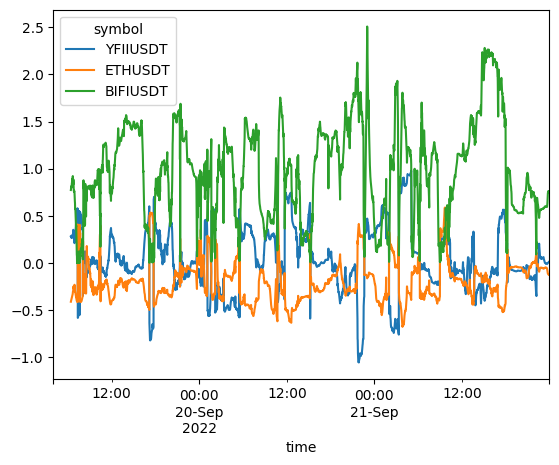

In [235]:
wgt_rolling.plot()

<Axes: xlabel='time'>

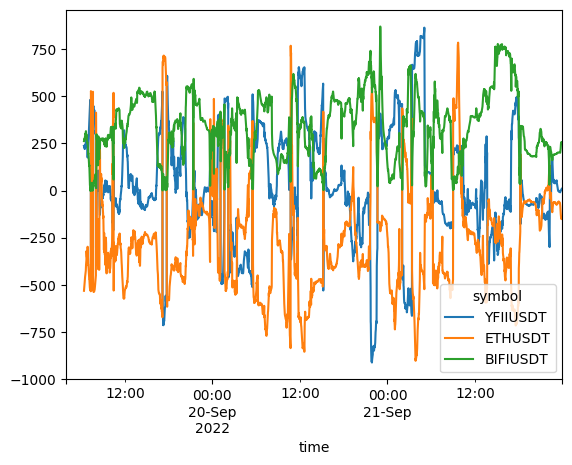

In [236]:
(get_close_between_date(1, symbols, date_str_20220919, date_str_20220922) * wgt_rolling).plot()

<Axes: xlabel='time'>

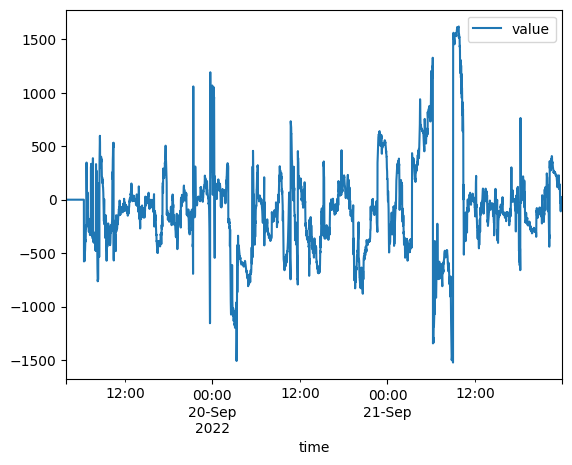

In [237]:
(get_close_between_date(1, symbols, date_str_20220919, date_str_20220922) * evecs_rolling).sum(axis=1).to_frame().rename(columns={0: 'value'}).plot()

In [317]:
trading_param = TradingParam(60, 1.5)
values_rolling = add_features(get_close_between_date(1, symbols, date_str_20220919, date_str_20220922), wgt_rolling, trading_param)

<Axes: xlabel='time'>

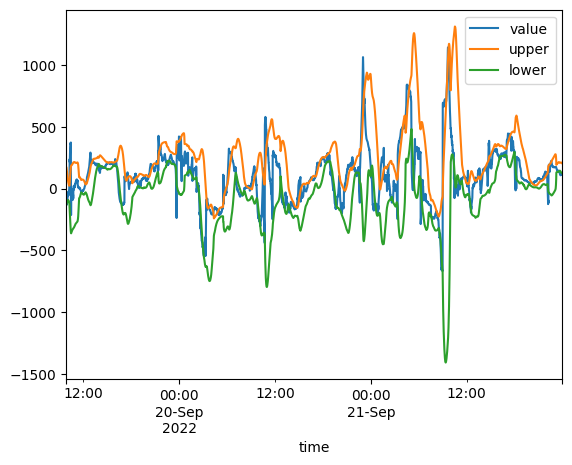

In [331]:
values_rolling[['value', 'upper', 'lower']].plot()

<Axes: xlabel='time'>

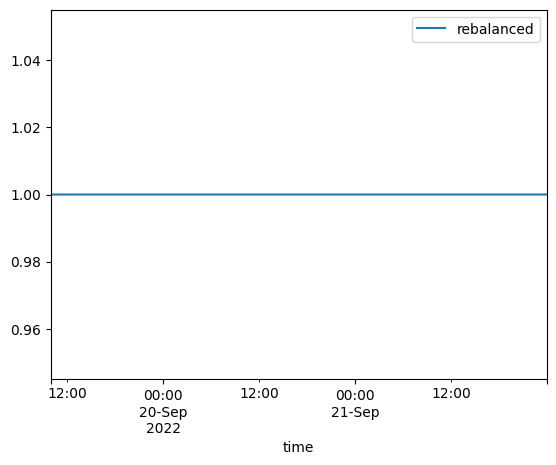

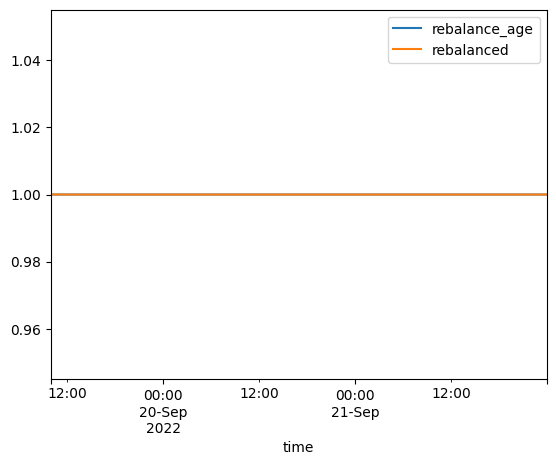

In [332]:
values_rolling[['rebalanced']].plot()
values_rolling[['rebalance_age', 'rebalanced']].plot()

<Axes: xlabel='time'>

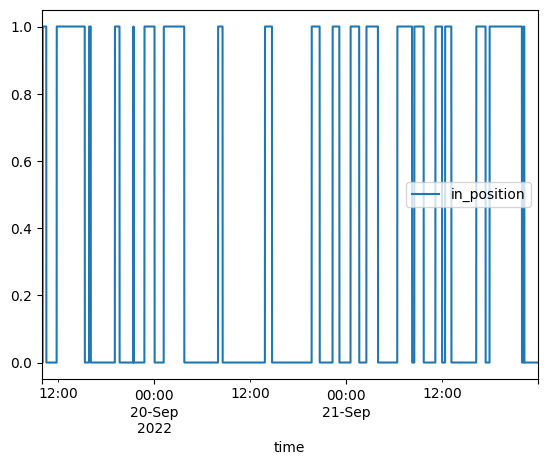

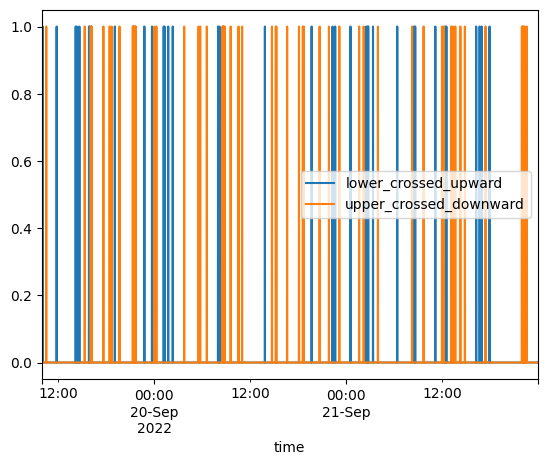

In [333]:
values_rolling[['in_position']].plot()
values_rolling[['lower_crossed_upward', 'upper_crossed_downward']].plot()

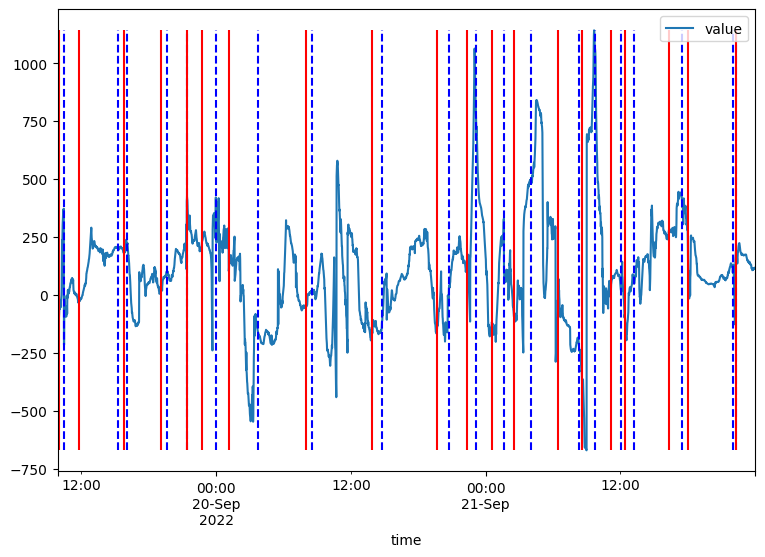

In [334]:
# plot dataframe; the index is a datetime index
#ax = values_rolling[['value', 'upper', 'lower']].plot(figsize=(9, 6))
ax = values_rolling[['value']].plot(figsize=(9, 6))
ymin, ymax = values_rolling.value.min(), values_rolling.value.max()

ax.vlines(x=list(values_rolling[values_rolling.position_changed == -1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values_rolling[values_rolling.position_changed == +1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

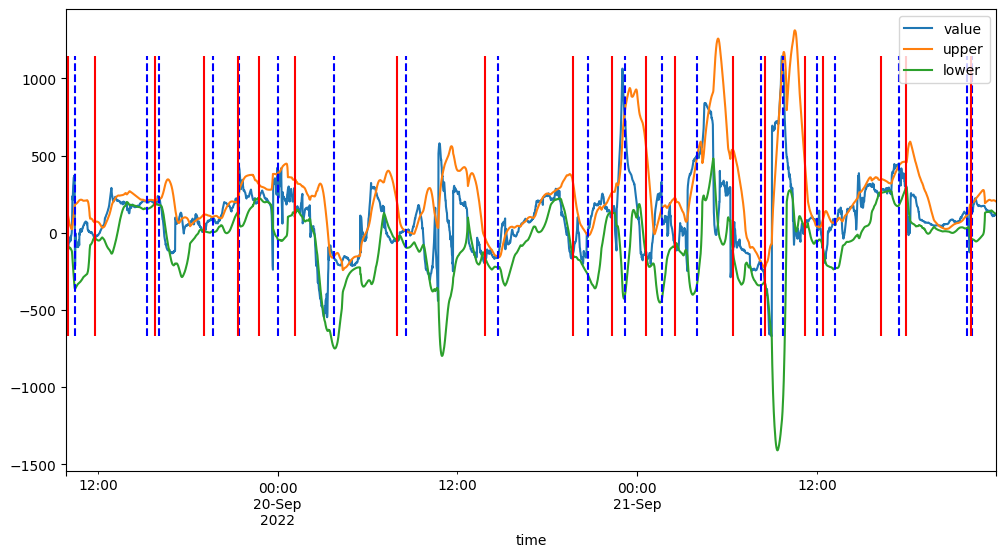

In [335]:
# plot dataframe; the index is a datetime index
#ax = values_rolling[['value', 'upper', 'lower']].plot(figsize=(9, 6))
ax = values_rolling[['value', 'upper', 'lower']].plot(figsize=(12, 6))
ymin, ymax = values_rolling.value.min(), values_rolling.value.max()

ax.vlines(x=list(values_rolling[values_rolling.position_changed == -1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values_rolling[values_rolling.position_changed == +1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

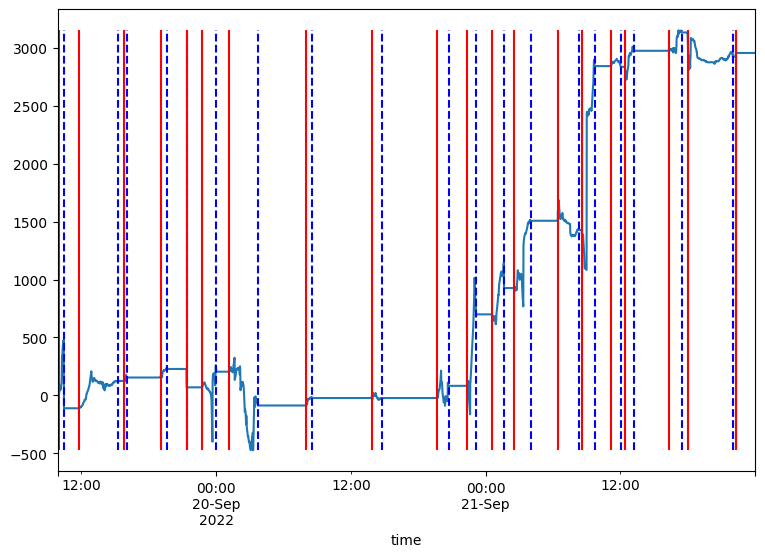

In [336]:
ax = values_rolling.profit_raw.cumsum().plot(figsize=(9, 6))
ymin, ymax = values_rolling.profit_raw.cumsum().min(), values_rolling.profit_raw.cumsum().max()

ax.vlines(x=list(values_rolling[values_rolling.position_changed == -1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values_rolling[values_rolling.position_changed == +1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()

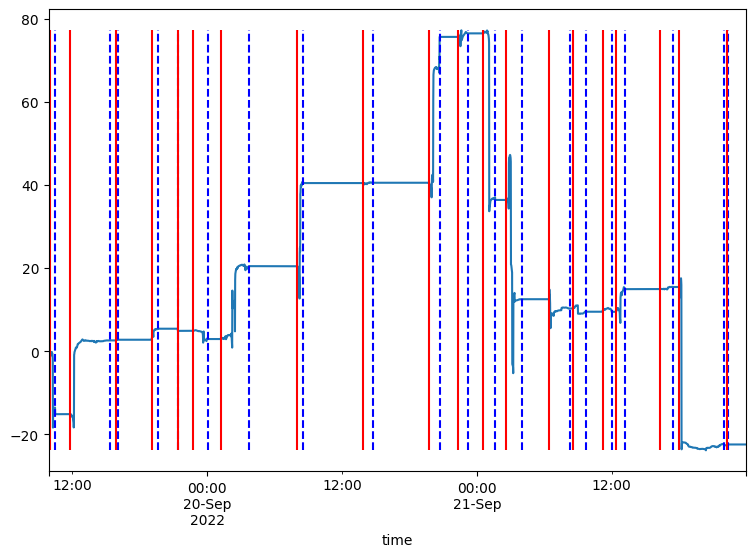

In [337]:
ax = values_rolling.profit.cumsum().plot(figsize=(9, 6))
ymin, ymax = values_rolling.profit.cumsum().min(), values_rolling.profit.cumsum().max()

ax.vlines(x=list(values_rolling[values_rolling.position_changed == -1].index), ymin=ymin, ymax=ymax, color='b', linestyles='dashed', label='enter')
ax.vlines(x=list(values_rolling[values_rolling.position_changed == +1].index), ymin=ymin, ymax=ymax, color='r', linestyles='solid', label='leave')

plt.show()